# Experiment - UCI Banknote Authentication Dataset

**References**
* https://archive.ics.uci.edu/ml/datasets/banknote+authentication

##Setup

In [18]:
# package versions
!pip list | grep "numpy\|pandas\|torch\|sklearn"

numpy                         1.19.5        
pandas                        1.1.5         
pandas-datareader             0.9.0         
pandas-gbq                    0.13.3        
pandas-profiling              1.4.1         
sklearn                       0.0           
sklearn-pandas                1.8.0         
torch                         1.8.1+cu101   
torchsummary                  1.5.1         
torchtext                     0.9.1         
torchvision                   0.9.1+cu101   


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
SEED = 42

In [20]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

In [22]:
banknote = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt',
                       names=['variance', 'skewness', 'curtosis', 'entropy', 'labels'])

banknote.head()

,variance,skewness,curtosis,entropy,labels
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Data

In [23]:
data = banknote.iloc[:, 0:4]
targets = banknote.labels

scaler = StandardScaler()

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(data), targets.to_numpy(), test_size=0.2, random_state=SEED)

In [24]:
class BanknoteDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return item, label

In [25]:
training_data = BanknoteDataset(X_train, y_train)
test_data = BanknoteDataset(X_test, y_test)

In [26]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([64, 4]), torch.Size([64]))

## Model

In [27]:
class NN_Model(nn.Module):
    def __init__(self, input_dim):
        super(NN_Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 10)
        self.layer2 = nn.Linear(10, 5)
        self.layer3 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x

In [28]:
class Ada_Act_Params(nn.Module):
    def __init__(self, k0, k1):
        super(Ada_Act_Params, self).__init__()
        self.K = torch.nn.Parameter(torch.tensor([k0, k1]))

    def forward(self, x):
        return self.K[0] + (self.K[1] * x)
    
class Ada_Act_Rand(nn.Module):
    def __init__(self):
        super(Ada_Act_Rand, self).__init__()
        self.values = torch.rand(2)
        self.K = torch.nn.Parameter(torch.tensor(self.values.tolist()))

    def forward(self, x):
        return self.K[0] + (self.K[1] * x)

In [29]:
class NN_Model_Monk(nn.Module):
    def __init__(self, input_dim, k0=None, k1=None):
        super(NN_Model_Monk, self).__init__()
        self.layer1 = nn.Linear(input_dim, 10)
        self.layer2 = nn.Linear(10, 5)
        self.layer3 = nn.Linear(5, 1)

        if k0 and k1:
            self.ada_act = Ada_Act_Params(k0, k1)
        else:
            self.ada_act = Ada_Act_Rand()

    def forward(self, x):
        x = self.ada_act(self.layer1(x))
        x = self.ada_act(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x

In [30]:
def train(dataloader, model, loss_fn, optimizer):
    train_loss = []
    pred_all = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # loss = loss_fn(pred, y.view(-1,1).float())
        loss = loss_fn(pred.flatten(), y.float())
        
        train_loss.append(loss.item())
        pred_all += (pred.flatten() > 0.5).long().tolist()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_acc = metrics.accuracy_score(dataloader.dataset.labels, pred_all)
    return (sum(train_loss)/len(train_loss), train_acc)

In [31]:
def test(dataloader, model):
    model.eval()
    test_loss = 0
    pred_all = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, y.view(-1, 1).float()).item()
            # test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

            pred_all += (pred.flatten() > 0.5).long().tolist()
    
    test_loss /= len(dataloader)
    test_acc = metrics.accuracy_score(dataloader.dataset.labels, pred_all)
    test_f1 = metrics.f1_score(dataloader.dataset.labels, pred_all)
    
    return (test_loss, test_acc, test_f1)

## Experiment 1 - ReLU

In [32]:
model = NN_Model(training_data.data.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

EPOCHS = 30

train_info = []
test_info = []
for epoch in range(EPOCHS):
    train_epoch = train(train_dataloader, model, loss_fn, optimizer)
    test_epoch = test(test_dataloader, model)
    
    train_info.append(train_epoch)
    test_info.append(test_epoch)
    if epoch % 10 == 9:
        print("EPOCH: {0}, Train loss: {1}, Train acc: {2}, Test loss: {3}, Test acc: {4}, Test F1: {5}".format(
            epoch, train_epoch[0], train_epoch[1], test_epoch[0], test_epoch[1], test_epoch[2]))

print("Done!")

EPOCH: 9, Train loss: 0.5934862130218082, Train acc: 0.5597082953509571, Test loss: 0.5869539499282836, Test acc: 0.5381818181818182, Test F1: 0.0
EPOCH: 19, Train loss: 0.3261442813608382, Train acc: 0.9462169553327257, Test loss: 0.3330319881439209, Test acc: 0.9272727272727272, Test F1: 0.9145299145299145
EPOCH: 29, Train loss: 0.10721694181362788, Train acc: 0.9735642661804923, Test loss: 0.11988641023635864, Test acc: 0.9781818181818182, Test F1: 0.9765625
Done!


Text(0, 0.5, 'test acc')

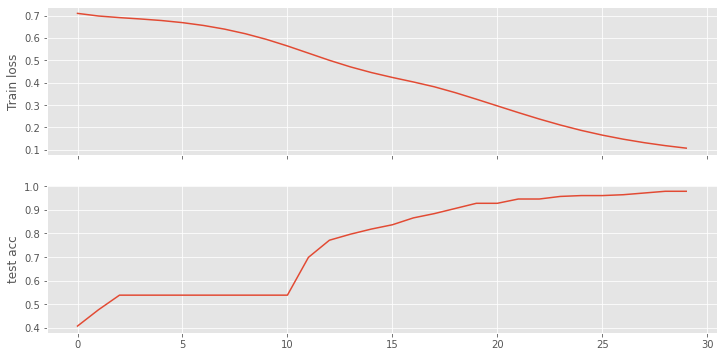

In [33]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(list(zip(*train_info))[0])
ax1.set_ylabel("Train loss")
ax2.plot(list(zip(*test_info))[1])
ax2.set_ylabel("test acc")

## Experiment 2 - Ada_Act_Params

In [34]:
# set ada_act params
k0 = 0.5
k1 = 0.5

model_monk_params = NN_Model_Monk(training_data.data.shape[1], k0, k1).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_monk_params.parameters(), lr=0.001, weight_decay=0.0001)

EPOCHS = 30

train_info = []
test_info = []
for epoch in range(EPOCHS):
    train_epoch = train(train_dataloader, model_monk_params, loss_fn, optimizer)
    test_epoch = test(test_dataloader, model_monk_params)
    
    train_info.append(train_epoch)
    test_info.append(test_epoch)
    if epoch % 10 == 9:
        print("EPOCH: {0}, Train loss: {1}, Train acc: {2}, Test loss: {3}, Test acc: {4}, Test F1: {5}".format(
            epoch, train_epoch[0], train_epoch[1], test_epoch[0], test_epoch[1], test_epoch[2]))

print("Done!")

EPOCH: 9, Train loss: 0.35960318479273057, Train acc: 0.9006381039197813, Test loss: 0.3545867562294006, Test acc: 0.88, Test F1: 0.8619246861924685
EPOCH: 19, Train loss: 0.07686370838847426, Train acc: 0.9717411121239745, Test loss: 0.08673067539930343, Test acc: 0.9781818181818182, Test F1: 0.9765625
EPOCH: 29, Train loss: 0.040952714160084724, Train acc: 0.9808568824065633, Test loss: 0.04911234453320503, Test acc: 0.9781818181818182, Test F1: 0.9765625
Done!


In [35]:
print(model_monk_params.ada_act.K)

Parameter containing:
tensor([0.4042, 0.9843], requires_grad=True)


Text(0, 0.5, 'test acc')

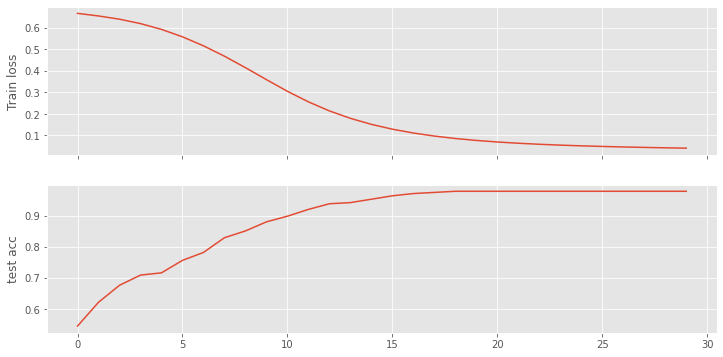

In [36]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(list(zip(*train_info))[0])
ax1.set_ylabel("Train loss")
ax2.plot(list(zip(*test_info))[1])
ax2.set_ylabel("test acc")

## Experiment 3 - Ada_Act_Rand

In [37]:
model_monk_rand = NN_Model_Monk(training_data.data.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_monk_rand.parameters(), lr=0.001, weight_decay=0.0001)

EPOCHS = 30

train_info = []
test_info = []
for epoch in range(EPOCHS):
    train_epoch = train(train_dataloader, model_monk_rand, loss_fn, optimizer)
    test_epoch = test(test_dataloader, model_monk_rand)
    
    train_info.append(train_epoch)
    test_info.append(test_epoch)
    if epoch % 10 == 9:
        print("EPOCH: {0}, Train loss: {1}, Train acc: {2}, Test loss: {3}, Test acc: {4}, Test F1: {5}".format(
            epoch, train_epoch[0], train_epoch[1], test_epoch[0], test_epoch[1], test_epoch[2]))

print("Done!")

EPOCH: 9, Train loss: 0.6887297100490994, Train acc: 0.5597082953509571, Test loss: 0.6901520490646362, Test acc: 0.5381818181818182, Test F1: 0.0
EPOCH: 19, Train loss: 0.6258773903052012, Train acc: 0.7848678213309025, Test loss: 0.6177546262741089, Test acc: 0.7636363636363637, Test F1: 0.7410358565737052
EPOCH: 29, Train loss: 0.228791453772121, Train acc: 0.8979033728350045, Test loss: 0.25047701597213745, Test acc: 0.8763636363636363, Test F1: 0.8617886178861789
Done!


In [38]:
print(model_monk_rand.ada_act.values)

tensor([0.6514, 0.0148])


In [39]:
print(model_monk_rand.ada_act.K)

Parameter containing:
tensor([ 0.3692, -0.5658], requires_grad=True)


Text(0, 0.5, 'test acc')

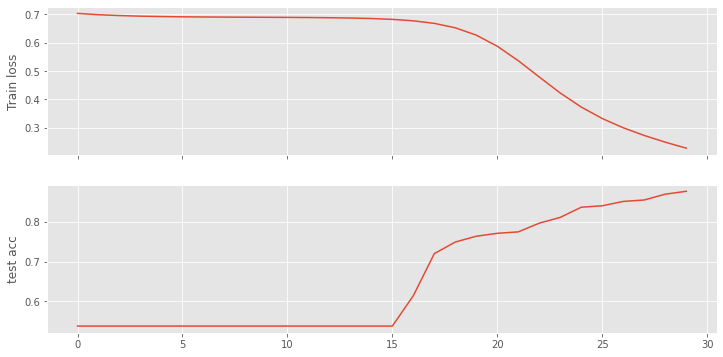

In [40]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(list(zip(*train_info))[0])
ax1.set_ylabel("Train loss")
ax2.plot(list(zip(*test_info))[1])
ax2.set_ylabel("test acc")